In [6]:
"""
import necessary modules
"""
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from scipy.interpolate import griddata
import numpy as np
from dorna2 import Dorna
from camera import Camera
from dorna_vision import Detection
import time
from tool import util
"""
parameters
"""
robot_ip_address = "192.168.1.102" # robot ip address
output_config = {
    "pick": [0, 1, 0],
    "pick_init": [0, 1, 0],
}

tcp = {
    "vial": [0, 0, 52, 0, 0, 0], #3
}

#{"cmd":"lmove","rel":0,"x":319.608745,"y":-196.888203,"z":115.801011,"a":-169.212841,"b":60.995684,"c":-0.033979}
frame = {
    "place": [320, -197, 60, -180, 0, 0]
}

imaging_joint = [0, 51.086426, -143.239746, 0, 2.131348, 0]
middle_joint = imaging_joint

corner=250

speed_pick = 0.6 # here set the speed of the robot
above = [10, 60, 60, 60]
motion = "lmove"
sim=0
freedom = {"num" : 10, "range" : [0.05,0.05,0.05], "early_exit": False }

# detection parameters
detection_prm = {
    "microplate":{
            "camera_mount":{
                "type": "dorna_ta_j4",
                "ej": [0 ,0,0, 0, 0, 0, 0, 0],
                "T": [46.5174596+1+1+1.5, 32.0776662-3+1-0-2-0.75, -4.24772615, -0.27547989, 0.27691881, 89.6939516],
            },
            'roi': {'corners': [[0, 0], [0, 479], [770, 479], [770, 0]], 'inv': False, 'crop': False}, 
            'detection': {'cmd': 'od', 'path': 'microplate.pkl', 'conf': 0.5, 'cls': []},
            'output': {'max_det': 100, 'shuffle': True, 'save_img': False, 'save_img_roi': False}
            },
    "vial":{
            #"camera_mount":{
            #    "type": "dorna_ta_j4",
            #    "ej": [0 ,0,0, 0, 0, 0, 0, 0],
            #    "T": [46.5174596+1+1+1.5, 32.0776662-3+1-0-2-0.75, -4.24772615, -0.27547989, 0.27691881, 89.6939516],
            #},
            'detection': {'cmd': 'od', 'path': 'vial.pkl', 'conf': 0.8, 'cls': []}, 
            'output': {'max_det': 100, 'shuffle': True, 'save_img': False, 'save_img_roi': False}
            }
    }
"""
detection_parameters = {
    "camera_mount":{
        "type": "dorna_ta_j4",
        "ej": [0 ,0,0, 0, 0, 0, 0, 0],
        "T": [46.5174596+1+1+1.5, 32.0776662-3+1-0-2-0.75, -4.24772615, -0.27547989, 0.27691881, 89.6939516],
    },
    'detection': {'cmd': 'od', 'path': 'vial.pkl', 'conf': 0.9, 'cls': []}, 
    #'limit': {'area': [0, 100000], 'aspect_ratio': [0.1, 1.0], 'xyz': [[190, 360], [-125, 125], [40, 47]], 'inv': 0},
    'output': {'max_det': 100, 'shuffle': True, 'save_img': True, 'save_img_roi': True},}
"""
# good candidate
xyz_min = 40
aspect_ratio = 0.9

# grasp
rvec_base = [180, 0, 0]
finger_location = [0, 90, 180, 270]
grasp_padding = 0 # pixel 3
gripper_opening = 12 # mm 12
gripper_thickness = 8 # pxl
bb_radius = 25 # pxl
pick_samples = 128
search_rotation = [-45, 50]
rvec_error_thr = 20 # mm
xyz_error_thr = 5 # mm

In [114]:
shape = [85, 125]
pxl_ref = np.array([
    [279, 153],
    [192, 31],
    [723, 20],
    [732, 365],
    [197, 366],
    [254, 300],
    [263, 80],
    [304, 15],
    [430, 13],
    [430, 157],
    [594, 98],
    [583, 271],
    [464, 193],
    [606, 127],
    [708, 176],
    [449, 343],
    [332, 292],
    [601, 212],
    [403, 160],
    [442, 115],
    [352, 112],
    [348, 217],
    [412, 196],
    [453, 174],
    [616, 33],
    [578, 93],
    [691, 261],
    [676, 287],
    [634, 310],
    [590, 334],
    [188, 108],
    [230, 168],
    [183, 208],
    [222, 251],
    [280, 345],
    [320, 301],
    [360, 345],
    [381, 301],
    [418, 344],
    # ,
    [726, 44],
    [630, 39],
    [553, 42],
    [409, 44],
    [332, 45],
    [240, 33],
    [744, 75],
    [738, 227],
    [748, 294],
    [754, 404],
    [187, 129],
    [192, 371],
    [342, 382],
    [464, 386],
    [644, 398],
    #
    [257, 106],
    [232, 57],
    [270, 58],
    [312, 60],
    [353, 60],
    [395, 59],
    [458, 48],
    [459, 90],
    [414, 92],
    [371, 94],
    [329, 95],
    [286, 98],
    [230, 112],
    [265, 154],
    [331, 131],
    [375, 152],
    [414, 155],
    [312, 202],
    #
    [517, 242],
    [515, 285],
    [580, 287],
    [681, 63],
    [643, 61],
    [568, 68],
    [503, 71],
    [434, 76],
    [443, 121],
    [483, 120],
    [523, 124],
    [583, 124],
    [621, 166],
    [553, 169],
    [441, 216],
    [566, 222],
    [478, 243],
    [214, 345],
    [265, 352],
    [328, 302],
    [227, 367],
    [697, 349],
])

xyz_ref = np.array([
    [290.90210028358894, 79.45882691588076, 45],
    [344.3598891767988, 117.90035871461907, 45],
    [350.1904187172848, -107.34523327411128, 45],
    [204.5069516941986, -110.55135398809965, 45],
    [201.25132034527442, 113.72582618881837, 45],
    [229.34564696427302, 89.138949864513, 45],
    [321.4944295389124, 87.50779637948679, 45],
    [350.70599135407906, 70.52116341656065, 45],
    [352.1628206379004, 16.225930787294054, 45],
    [289.49163727908984, 15.881618889965054, 45],
    [315.89784808122585, -52.112936482571385, 45],
    [243.0792456488096, -48.067271358361765, 45],
    [275.253159385206, 1.9444194138581636, 45],
    [303.9334330670534, -57.20419835735126, 45],
    [283.418498756174, -101.17327825408782, 45],
    [212.14158298651475, 7.917937061938289, 45],
    [233.41665886091624, 56.58740348932104, 45],
    [267.66999862744495, -55.39548447714354, 45],
    [288.5434535502941, 27.22536020498923, 45],
    [307.39553588898605, 10.908325990075102, 45],
    [308.45821502909627, 48.45709046150807, 45],
    [264.42425169755865, 50.000731068608815, 45],
    [273.4099052754199, 23.34352880207776, 45],
    [282.7672900921605, 6.203106097041072, 45],
    [344.4230915484399, -61.604720867953375, 45],
    [318.0863959210724, -44.54286990130542, 45],
    [247.90737025774132, -93.66525676728132, 45],
    [236.82952149094683, -87.59160398327872, 45],
    [226.98034004909206, -69.29674320580575, 45],
    [216.86936891522095, -50.78467372871498, 45],
    [309.87948657273967, 117.85438975669476, 45],
    [284.49063233721023, 100.54439513778848, 45],
    [267.48780428458326, 119.1745674308285, 45],
    [249.89321112906842, 102.80142638971905, 45], 
    [210.56755598965992, 78.39030678290776, 45],
    [229.54462100475206, 61.29680149363408, 45],
    [211.17109708713718, 44.82852133591946, 45],
    [229.74157755372133, 36.08106530565775, 45],
    [210.9808555180205, 20.505176027961557, 45],
    #,
    [340.18245727123997, -110.34567161709245, 45],
    [342.43559689362485, -68.25657986466592, 45],
    [339.2561299935528, -36.227185212593525, 45],
    [338.01274367547995, 25.398890560001544, 45],
    [337.690204031288, 58.006418868684854, 45],
    [342.48031478019857, 97.04747872694807, 45],
    [326.41965422922584, -115.90986469054586, 45],
    [262.5419087824239, -113.42370689646971, 45],
    [234.45456194159615, -117.23236385931939, 45],
    [188.1407384819805, -120.20382141805749, 45],
    [300.7253863861715, 117.9123937555441, 45],
    [199.3012726798179, 114.71566050437984, 45],
    [194.78042291143106, 52.23132585169587, 45],
    [194.06738972559396, 1.464042570585029, 45],
    [190.00238590746852, -73.90938319261556, 45],
    #
    [311.20454039211114, 89.42487139888419, 45.0],
    [332.2637347640504, 99.59442332477018, 44.99999999999999],
    [331.229737129205, 83.34188792064003, 45.000000000000014],
    [330.4058887347727, 66.4435600892604, 45.0],
    [331.04948360028396, 48.40988962446162, 45.00000000000002],
    [331.36016439732697, 30.78390876270239, 44.99999999999999],
    [336.4305192923815, 4.038835798438304, 45.000000000000014],
    [318.18407710766286, 4.202716420541573, 44.999999999999986],
    [317.54536991566306, 22.818600896865963, 44.99999999999999],
    [316.6218300334178, 41.15107716341326, 45.000000000000014],
    [316.01949524474804, 58.5570810905013, 45.000000000000014],
    [314.7750759127466, 76.92829548341956, 44.999999999999986],
    [309.1184614782194, 100.59667310290843, 44.99999999999998],
    [290.85085449545807, 85.18453723375991, 45.000000000000014],
    [300.30873336476054, 57.632320420505835, 45.000000000000014],
    [291.43564062636597, 39.21631880058538, 45.00000000000001],
    [290.91851093487037, 22.200627798328252, 45.00000000000001],
    [270.9643131582649, 66.21748445162204, 45.0],
    #
    [255.24121183320307, -19.989721791431464, 45.0],
    [237.3045617028844, -19.29631105710401, 44.99999999999999],
    [236.86186166189393, -46.7591380305167, 45.0],
    [332.05763969762415, -90.27999885403128, 45.00000000000001],
    [332.25705803283955, -73.4921726389482, 44.99999999999999],
    [329.0074193313702, -41.78058056501693, 45.0],
    [327.439164176147, -15.141697065694848, 44.99999999999997],
    [324.7338344892269, 13.584312662994593, 45.0],
    [305.2246330725316, 10.052113948076535, 45.0],
    [305.65251424091866, -6.2520789066290074, 44.999999999999986],
    [304.64104875939677, -23.061574032677992, 44.999999999999986],
    [304.9519955704018, -47.4871018853492, 44.99999999999999],
    [287.8651045597768, -64.60745837315439, 45.00000000000001],
    [286.62582062212016, -35.35477966726808, 45.0],
    [265.9617025373673, 10.969855670769473, 45.0],
    [264.2720866994009, -40.554703240485836, 44.999999999999986],
    [254.79232392722105, -4.417591163719901, 44.99999999999999],
    [210.2917403504503, 105.7676455505631, 45.0],
    [207.44250788145723, 84.03732042153298, 45.00000000000001],
    [228.3402680553343, 58.43911076690735, 45.00000000000001],
    [200.81779842837483, 100.6312021605221, 45.0],
    [211.4360171667975, -96.67684602342935, 44.999999999999986],
])

place_pose_list = [np.array([-i*9.1, -j*9.1, 0, 0, 0, 0])+ np.array(frame["place"]) for i in range(8) for j in range(12)]

In [ ]:
"""
initialize the robot, camera, and object detection
"""
robot = Dorna() # initialize robot
robot.connect(robot_ip_address) # connect to robot

camera = Camera() # initialize camera
camera.connect() # connect to camera

detection_microplate = Detection(camera=camera, robot=robot, **detection_prm["microplate"]) # initialize the object detection
detection_vial = Detection(camera=camera, robot=robot, **detection_prm["vial"]) # initialize the object detection


"""
init robot
"""
robot.tool(tcp=tcp["vial"]) # set the tcp
robot.set_output(output_config["pick_init"][0], output_config["pick_init"][2]) # set output
robot.set_motor(1) # turn on the robot motors
robot.sleep(1) # sleep to allow the robot to settle before moving

#set safe initial position
robot.go(joint=imaging_joint, speed=speed_pick, sim=sim)

"""
run the object microplate detection and pick and place
"""
for i in range(90):
    # always run this to make sure that the rbot is stationary before running the object detection
    time.sleep(0.1)
    result_microplate = detection_microplate.run()

    # init pose estimator
    bbox_microplate = [r["corners"] for r in result_microplate if r["cls"] == "microplate"]
    if not len(bbox_microplate):
        continue
    bbox_microplate = bbox_microplate[0]
    
    # vial detection
    padding = rvec_error_thr
    roi_vial = [[min(x for x, _ in bbox_microplate) - padding, min(y for _, y in bbox_microplate) - padding], 
            [max(x for x, _ in bbox_microplate) + padding, min(y for _, y in bbox_microplate) - padding], 
            [max(x for x, _ in bbox_microplate) + padding, max(y for _, y in bbox_microplate) + padding], 
            [min(x for x, _ in bbox_microplate) - padding, max(y for _, y in bbox_microplate) + padding]]
    result_vial = detection_vial.run(roi={'corners': roi_vial, 'inv': False, 'crop': True})

    
    # assign tcp and tvec
    for r in [r for r in result_vial if r["cls"] in tcp]:
        # fine tuned xyz
        xyz_interp = griddata(pxl_ref, xyz_ref, r["center"], method='cubic')
        r["tvec"] = [xyz_interp[0][0], xyz_interp[0][1], xyz_interp[0][2]]
        r["xyz"] = [xyz_interp[0][0], xyz_interp[0][1], xyz_interp[0][2]]

        # assign tcp
        r["tcp"] = tcp[r["cls"]]


    # best_pick
    best_pick_result = util.best_pick(result_vial, 
                                    rvec_base, 
                                    detection_vial.camera_data["joint"], 
                                    robot, detection_vial.frame_mat_inv, 
                                    camera.camera_matrix(detection_vial.camera_data["depth_int"]), 
                                    camera.dist_coeffs(detection_vial.camera_data["depth_int"]), 
                                    grasp_padding, gripper_opening, freedom, gripper_thickness, xyz_min, aspect_ratio, pick_samples, search_rotation, finger_location, bb_radius)

    if best_pick_result is None:
        print("no pick")
        continue
    # assign
    pick_pose, label, pxl_list, o, pose_valid_list, pose_not_valid_list, detection_result = best_pick_result

    
    # pick
    retval = robot.pick_n_place(
        pick_pose=detection_result["tvec"]+pick_pose[3:], # pick position we got from detection
        place_pose=place_pose_list[i], # place poistion which we got from the class
        end_joint=imaging_joint,
        tcp=detection_result["tcp"], # tcp is the tool length and postion which we deffined in the cfg cell
        speed=speed_pick, # speed which we also defined in the cfg cell
        output_config = output_config["pick"], # output in order (pin, off state, on state)
        above=above,
        #pick_cmd_list=[{"cmd":"output", "out"+str(output_config["pick"][0]): output_config["pick"][2], "queue":0},
        #{"cmd": "sleep", "time": 0.5}],
        motion=motion,
        sim=sim,
        freedom = freedom
        )

    #print(detection_result["tvec"], o)
robot.close() # close robot
camera.close() # close camera
detection_microplate.close() # close object detection
detection_vial.close()

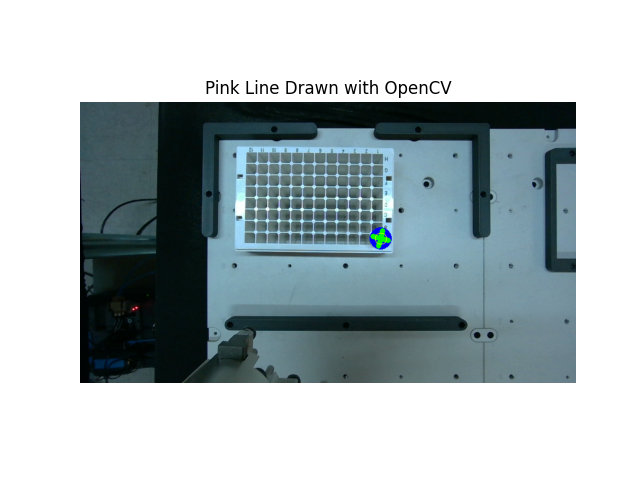

In [13]:
%matplotlib widget
import matplotlib.pyplot as plt
import cv2 as cv
# draw start end
img = detection_vial.camera_data["color_img"].copy()

color = (255, 105, 180)  # Pink line

# Define thickness of the line
thickness = gripper_thickness

# good
for p in pose_valid_list:
    for pxl in p[1]:
        cv.line(img, pxl, p[2], (255, 0, 0), thickness)


"""
# bad
for p in pose_not_valid_list:
    for pxl in p[1]:
        cv.line(img, pxl, p[2], (0, 0, 255), thickness)
"""
# best
for pxl in pxl_list:
    cv.line(img, pxl, o, (0, 255, 0), thickness)

# pick
for r in result_vial:
    cv.circle(img, r["center"], 10, (0, 255, 255), 1)

# Convert BGR to RGB for Matplotlib
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)


plt.imshow(img_rgb)
plt.title("Pink Line Drawn with OpenCV")
plt.axis("off")  # Turn off axis
plt.show()